# Classifying Cardiovascular Diseases in a Cheap(?) Way!

### Introduction

Cardiovascular diseases (CVD's) collectively describe a group of disorders involving the heart and blood vessels surrounding it. Research around cardiovascular diseases have been a subject of great interest as it is estimated that 17.9 million lives are claimed by CVD's each year worldwide. The presence of CVD's correlate with age and cardiovascular related hereditary diseases (type 2 diabetes, thalassemia, Etc.), and some common behavioral risk factors such as smoking, unhealthy diet, abstinence of physical exercise, and excessive alcohol consumption. Common tests to diagnose CVDs include blood work, measurements with an electrocardiogram, ambulatory monitoring, echocardiogram, cardiac CT's and MRI's, and stress tests. However, an accurate diagnosis still requires much manual analysis integrating laboratory data and patient information. Thus, manual diagnosis can be complex and time consuming while depending greatly on the physicians' experience. Moreover, in facilities with limited resources, the accuracy for diagnosing CVDs could further suffer. One can imagine that a lack of diagnostic apparatuses, low physician-to-patient ratios, and shortage of medical expertise can result in poor prediction and treatment of heart patients. Here we explore whether an artificial intelligence (AI) model that consumes simple predictors (gathered without advanced machineries and high quality expertise) could accurately predict the presence of cardiovascular diseases in patients.

The datasets which we will use to develop our AI model are taken from the UCI Machine Learning Repository (https://archive.ics.uci.edu/ml/datasets/Heart+Disease). The data was collected from patients in the following locations:

1. Cleveland Clinic Foundation
2. Hungarian Institute of Cardiology, Budapest
3. V.A. Medical Center, Long Beach, CA
4. University Hospital, Zurich, Switzerland

Each location compiled a separate database that contains 76 recorded attributes for each individual in their list of heart patients. For our purposes, we are going to focus on a subset of 7 attributes from a combined dataset from all four locations. The 7 attributes are as follows:

1. `age` - age of patients
2. `sex` - sex of patients
3. `exang` - exercised induced angina. Angina is a type of chest pain caused by reduced blood flow to the heart.
4. `oldpeak` - ST depression induced by exercise relative to rest. A measurement taken from a patient's electrocardiogram.
5. `slope` - Slope of the peak exercise ST segment. A measurement taken from a patient's electrocardiogram.
6. `thal` - thalassemia is an inherited blood disorder that causes your body to have less hemoglobin than normal. 
7. `num` - categorization of the severity of CVD in 0 to 4, with "0" being free of CVD.

In [1]:
#Loading Packages
library(tidyverse)
library(tidymodels)
library(RColorBrewer)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [2]:
#Loading the Data
cleveland_data <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data", col_names = FALSE)
hungarian_data <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.hungarian.data", col_names = FALSE)
switzerland_data <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.switzerland.data", col_names = FALSE)
va_data <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.va.data", col_names = FALSE)

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 294 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): X4, X5, X6, X7, X8, X9, X11, X12, X13
dbl (5): X1, X2, X3, X10, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 123 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): X4, X6, X7, X8, X9, X10, X11, X12, X13
dbl (5): X1, X2, X3, X5, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or 

In [3]:
#Adding an origin category for each row
cleveland_data <- mutate(cleveland_data, Origin = "cleveland")
hungarian_data <- mutate(hungarian_data, Origin = "hungarian")
switzerland_data <- mutate(switzerland_data, Origin = "switzerland")
va_data <- mutate(va_data, Origin = "longbeach")

#Combining the data into a mega data set
heart_data <- rbind(cleveland_data, hungarian_data, switzerland_data, va_data)

#Creating names for each column
column_names = c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exercise_induced_angina", "st_depression", "st_segment_slope", "ca", "thalassemia", "presence_of_cvd", "origin")

#Adding names to columns
colnames(heart_data) <- column_names
head(heart_data)

#Selecting the columns of interest
heart_data <- heart_data |> select(age, sex, exercise_induced_angina, st_depression, st_segment_slope, thalassemia, presence_of_cvd, origin)

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exercise_induced_angina,st_depression,st_segment_slope,ca,thalassemia,presence_of_cvd,origin
<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0,cleveland
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2,cleveland
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1,cleveland
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0,cleveland
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0,cleveland
56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0,cleveland


### Tidying the Data



In [4]:
#Removing all rows that with missing variable(s)
tidy_data <- heart_data |> filter(exercise_induced_angina != "?" & st_depression != "?" & st_segment_slope != "?" & thalassemia != "?")

#Combining heart severity levels 1 to 4 into one measurement and converting variables in presence_of_cvd into "Yes" or "No"
severity_1_to_4 <- tidy_data |> filter(presence_of_cvd != 0) |> mutate(presence_of_cvd = "Yes")
tidy_data <- tidy_data |> filter(presence_of_cvd == 0) |> mutate(presence_of_cvd = "No") |> rbind(severity_1_to_4)

#Converting variables in sex into "M" or "F"
males <- tidy_data |> filter(sex != 0) |> mutate(sex = "M")
tidy_data <- tidy_data |> filter(sex == 0) |> mutate(sex = "F") |> rbind(males)

#Converting variables in exercise_induced_angina into "No" or "Yes"
not_induced <- tidy_data |> filter(exercise_induced_angina == 0) |> mutate(exercise_induced_angina = "No")
tidy_data <- tidy_data |> filter(exercise_induced_angina == 1) |> mutate(exercise_induced_angina = "Yes") |> rbind(not_induced)

#Converting  variables in thalassemia into more intuitive variables
tidy_data <- tidy_data |> mutate(thalassemia = as.character(thalassemia))
no_presence <- tidy_data |> filter(thalassemia == "3" | thalassemia == "3.0") |> mutate(thalassemia = "No Presence")
fixed_defect <- tidy_data |> filter(thalassemia == "6" | thalassemia == "6.0") |> mutate(thalassemia = "Fixed Defect")
tidy_data <- tidy_data |> filter(thalassemia == "7" | thalassemia == "7.0") |> mutate(thalassemia = "Reversable Defect") |> rbind(no_presence, fixed_defect)

head(tidy_data)

age,sex,exercise_induced_angina,st_depression,st_segment_slope,thalassemia,presence_of_cvd,origin
<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
51,F,Yes,1.2,2,Reversable Defect,Yes,cleveland
61,F,Yes,1,2,Reversable Defect,Yes,cleveland
43,F,Yes,3,2,Reversable Defect,Yes,cleveland
56,F,Yes,4,3,Reversable Defect,Yes,cleveland
56,F,Yes,1.9,2,Reversable Defect,Yes,cleveland
66,F,Yes,1,2,Reversable Defect,Yes,cleveland


In [5]:
#Creating training and testing data set. We decided on a 75-25 split and give the majority set as the training set to ensure 
set.seed(1)
split_data <- initial_split(tidy_data, prop = 0.75, strata = presence_of_cvd)
training_data <- training(split_data)
testing_data <- testing(split_data)

### Preliminary Exploratory Data Analysis

In [6]:
#Summary of number of rows in the mega data set, tidied data set, deleted rows from mega data set to create tidied data set, and training data set.
nrows_in_raw_dataset <- nrow(heart_data)
nrows_in_tidied_dataset <- nrow(tidy_data)
nrows_in_training_datatset <- nrow(training_data)
raw_stats <- data.frame(nrows_in_raw_dataset, nrows_in_tidied_dataset) |> 
    mutate(nrows_with_missing_data = nrows_in_raw_dataset - nrows_in_tidied_dataset) |>
    mutate(nrows_in_training_set = nrows_in_training_datatset)
raw_stats

#Summary of patients with CVD in training data set
training_stats <- training_data |> 
    group_by(presence_of_cvd) |> 
    count() |> 
    pivot_wider(names_from = presence_of_cvd, values_from = n) |> 
    rename(patients_with_CVD = No, patients_without_CVD = Yes) |> 
    mutate(total_count_in_training_data = nrows_in_training_datatset)
training_stats

#Summary of presence of CVD in training data grouped by patient origins
summary <- training_data |> 
    group_by(origin, presence_of_cvd) |> 
    count() |> 
    pivot_wider(names_from = presence_of_cvd, values_from = n) |> 
    rename(origin_in_training_data = origin, patients_with_CVD = No, patients_without_CVD = Yes)
summary

nrows_in_raw_dataset,nrows_in_tidied_dataset,nrows_with_missing_data,nrows_in_training_set
<int>,<int>,<int>,<int>
920,385,535,288


patients_with_CVD,patients_without_CVD,total_count_in_training_data
<int>,<int>,<int>
128,160,288


origin_in_training_data,patients_with_CVD,patients_without_CVD
<chr>,<int>,<int>
cleveland,122,107
hungarian,4,4
longbeach,1,10
switzerland,1,39


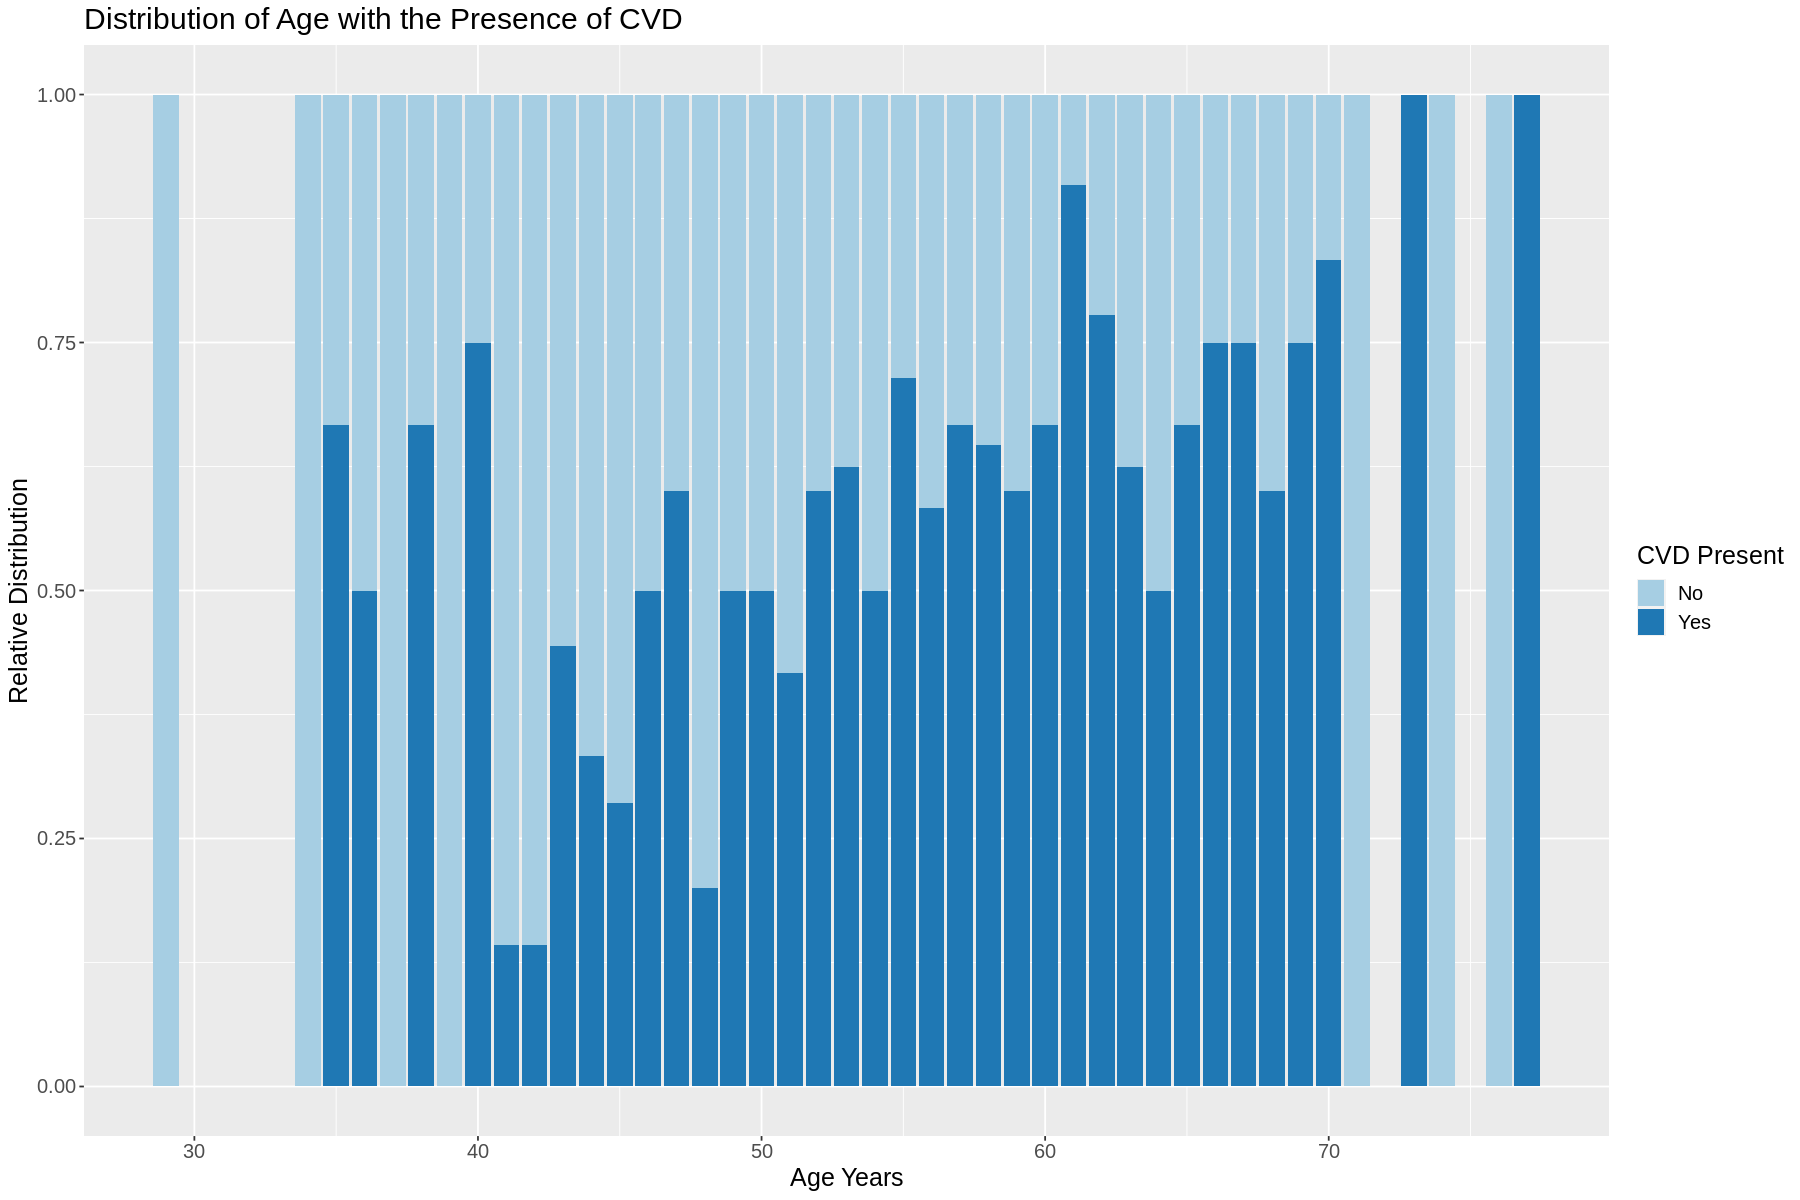

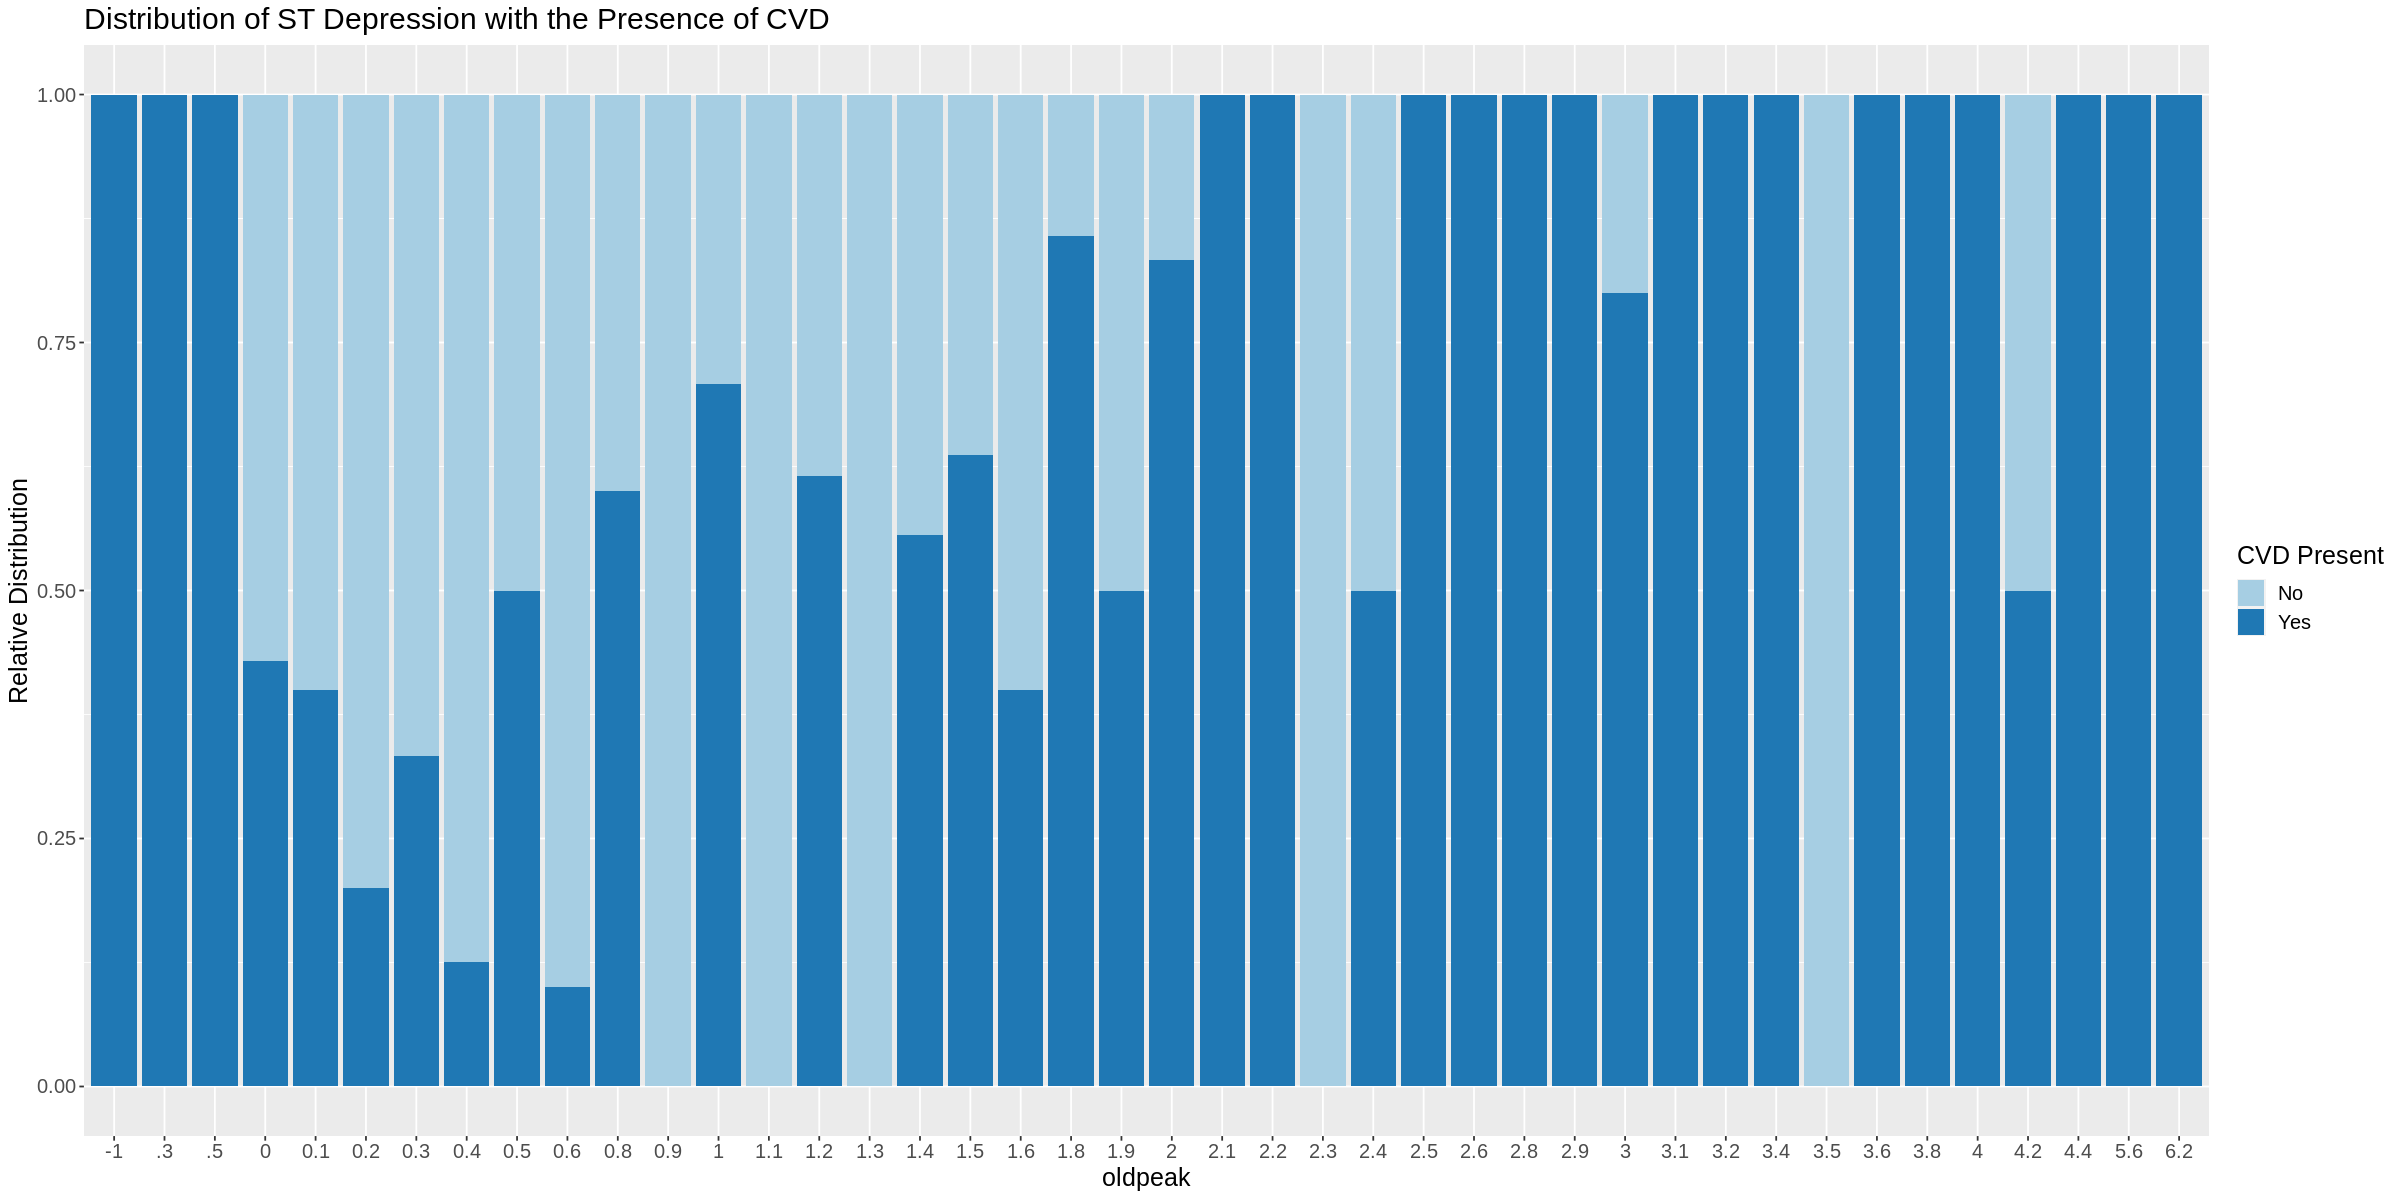

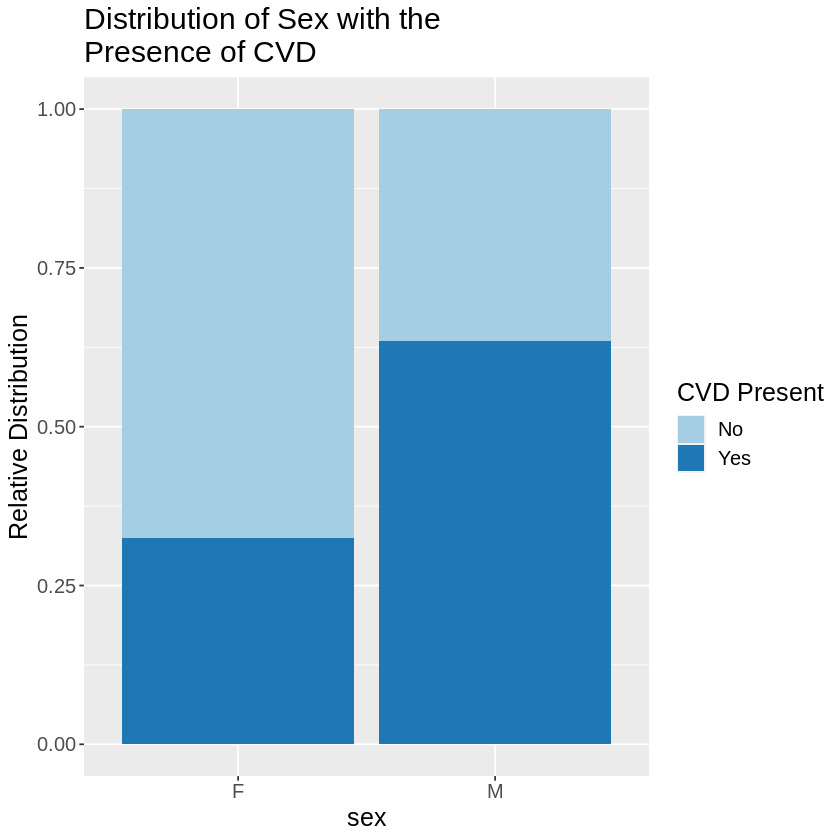

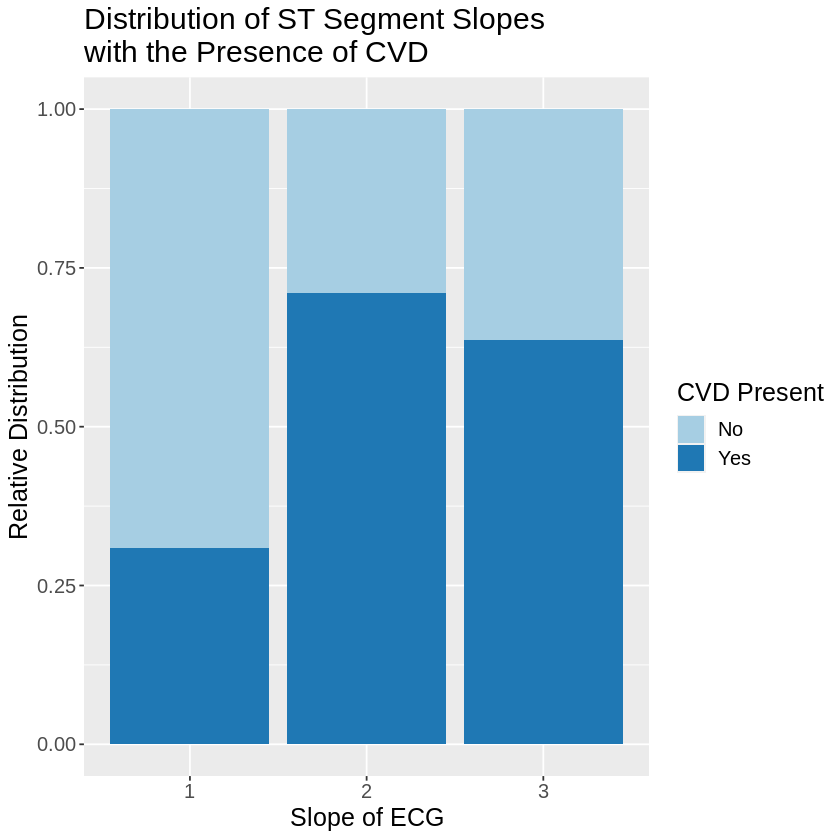

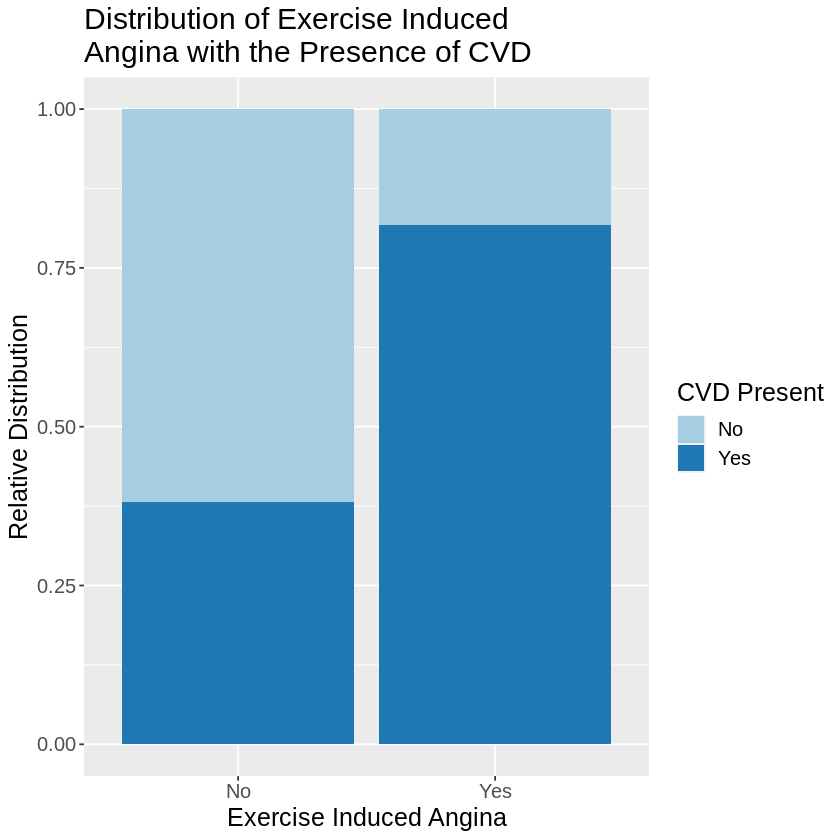

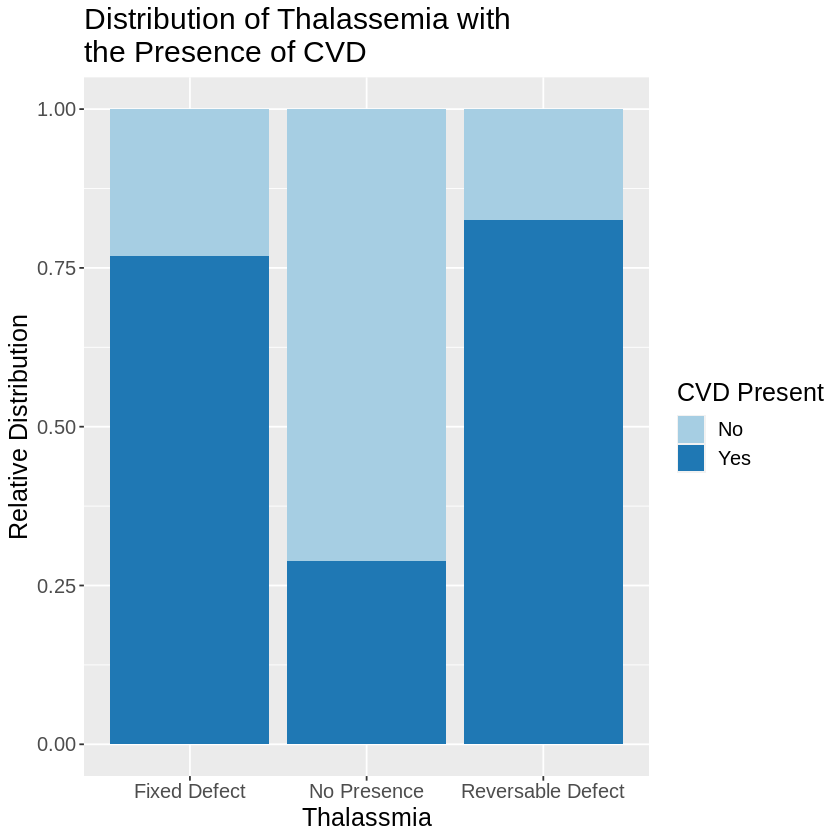

In [7]:
#Age versus presence of CVD. Here we see that Age correlates with the presence of CVD.
options(repr.plot.width = 15, repr.plot.height = 10)
age_vs_pred <- training_data |>
    ggplot(aes(x = age, fill = as_factor(presence_of_cvd))) +
    geom_bar(position = "fill") + 
    labs(x = "Age Years", y = "Relative Distribution", fill = "CVD Present") + theme(text = element_text(size = 15)) +
    ggtitle("Distribution of Age with the Presence of CVD") +
    scale_fill_brewer(palette = 'Paired')
age_vs_pred

#ST depression versus presence of CVD. Here we see that there is a certain range of ST depression (0.5 to 1.8) that has the least presence of CVD.
options(repr.plot.width = 20, repr.plot.height = 10)
st_depression_plot <- ggplot(training_data, aes(x = st_depression, fill = as_factor(presence_of_cvd))) +
    geom_bar(position = "fill") + 
    labs(x = "oldpeak", y = "Relative Distribution", fill = "CVD Present") + theme(text = element_text(size = 15)) +
    ggtitle("Distribution of ST Depression with the Presence of CVD") +
    scale_fill_brewer(palette = 'Paired')
st_depression_plot

#Sex versus presence of CVD. Here we see that the relative presence of CVD is different for each sex.
options(repr.plot.width = 7, repr.plot.height = 7)
sex_plot <- ggplot(training_data, aes(x = sex, fill = as_factor(presence_of_cvd))) +
    geom_bar(position = "fill") + 
    labs(x = "sex", y = "Relative Distribution", fill = "CVD Present") + theme(text = element_text(size = 15)) +
    ggtitle("Distribution of Sex with the  \nPresence of CVD") +
    scale_fill_brewer(palette = 'Paired')
sex_plot

#ST slope versus presence of CVD. Here we see that slope > 1 have increased presence of CVD.
st_segment_slope_plot <- ggplot(training_data, aes(x = st_segment_slope, fill = as_factor(presence_of_cvd))) +
    geom_bar(position = "fill") + 
    labs(x = "Slope of ECG", y = "Relative Distribution", fill = "CVD Present") + theme(text = element_text(size = 15)) +
    ggtitle("Distribution of ST Segment Slopes  \nwith the Presence of CVD") +
    scale_fill_brewer(palette = 'Paired')
st_segment_slope_plot

#Exercise induced angina versus presence of CVD. Here we see that presence of exercise induced angina has a significantly higher presence of CVD.
exercise_induced_angina_plot <- ggplot(training_data, aes(x = exercise_induced_angina, fill = as_factor(presence_of_cvd))) +
    geom_bar(position = "fill") + 
    labs(x = "Exercise Induced Angina", y = "Relative Distribution", fill = "CVD Present") + theme(text = element_text(size = 15)) +
    ggtitle("Distribution of Exercise Induced \nAngina with the Presence of CVD") +
    scale_fill_brewer(palette = 'Paired')
exercise_induced_angina_plot

#Thalassemia versus presence of CVD. Here we see that the presence of any form of thalassemia correlates with higher presence of CVD.
thalassemia_plot <- ggplot(training_data, aes(x = thalassemia, fill = as_factor(presence_of_cvd))) +
    geom_bar(position = "fill") + 
    labs(x = "Thalassmia", y = "Relative Distribution", fill = "CVD Present") + theme(text = element_text(size = 15)) +
    ggtitle("Distribution of Thalassemia with  \nthe Presence of CVD") +
    scale_fill_brewer(palette = 'Paired')
thalassemia_plot

### Methodology

The artificial intelligene model we'll be developing will be a classification model using K-Nearest Neighbors (KNN). We will use all the columns in our tidied data set (except for the predicted vector) as our predictors. The best way to visualize the accuracy of classifier would be by producing a confusion matrix. From the confusion matrix we would be able to calculate values such as proportions of true/false positives and negatives.

### Expected Outcomes and Significance

We expect to our classifier model to have a significantly better accuracy than the baseline of our majority classifier (+55% in our case).

If our classifier model is very accurate, then our model could have practical uses in facilities that lack sophisticated diagnostic machines, have low physician-to-patient ratios, and shortage of medical expertise. A simple diagnostic circuit (that puts a value for each of our predictors) could be implemented in medicial facilities. CVD would be more efficiently detected, and patients could have their conditions treated sooner.

In developing our classifier model, we should spend a great detail of introspection on choosing our predictors and coming up with additional predictors that could better our classifier model's accuracy.